# Can we classify open clusters and globular clusters using their B-V index and true diameter?

## Abstract

## Introduction

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn import metrics
import sklearn as sk

## Reading the Data

In [2]:
## Functions to calculate diameter of clusters
def get_angular_size(r_h):
	'''Go  from half light radius to true radius, based on King (1966) model for half light radius.
	Takes half light radius, in arcmin, and multiply by 2.5 to get angular radius.
	Multiply by 2 again to get angular diameter (angular size)
	'''
	return 2.5 * r_h * 2


def get_true_diameter(angular_size, dist):
	'''Takes angular size, in arcmin, and distance from Sun, in pc,
	Calculates true diameter (in pc)
	'''
	diam_rad = angular_size * (2.9089 * 10**-4) # 2.9089 * 10^-4 rad = 1 arcmin
	return diam_rad * dist 


In [3]:
def get_angular_size(r_h):
	'''Go  from half light radius to true radius, based on King (1966) model for half light radius.
	Takes half light radius, in arcmin, and multiply by 2.5 to get angular radius.
	Multiply by 2 again to get angular diameter (angular size)
	'''
	return 2.5 * r_h * 2


def get_true_diameter(angular_size, dist):
	'''Takes angular size, in arcmin, and distance from Sun, in pc,
	Calculates true diameter (in pc)
	'''
	diam_rad = angular_size * (2.9089 * 10**-4) # 2.9089 * 10^-4 rad = 1 arcmin
	return diam_rad * dist 


# GLOBULAR CLUSTER DATA READING
glob_data1 = pd.read_csv("glob_data.txt", skiprows = 72, nrows = 157, delim_whitespace = True, header = None)
glob_data2 = pd.read_csv("glob_data.txt", skiprows = 252, nrows = 157, delim_whitespace = True, header = None)
glob_data3 = pd.read_csv("glob_data.txt", skiprows = 433, nrows = 157, delim_whitespace = True, header = None)

# Combining the first two columns because the names were split
glob_data1["Cname"] = glob_data1.iloc[:,0] + glob_data1.iloc[:,1].astype(str)


glob_data = pd.concat([glob_data1["Cname"], glob_data1.iloc[:,4:10], glob_data1.iloc[:,10], glob_data2.iloc[:,4], glob_data3.iloc[:,9]], axis = 1)
glob_data.columns = ["Cname", "RA1", "RA2","RA3", "Dec1", "Dec2", "Dec3", "R_sun", "E(B-V)","r_h" ]
glob_data = glob_data.dropna()

# OPEN CLUSTER DATA READING
open_data = pd.read_csv("open_data.tsv", skiprows = 39, delimiter = "\t", header = None)

# Code generated by ChatGPT-4o (OpenAI, 2024) - November 2024 version, Prompt: "I have too many whitespace missing values in my dataset, how do I remove them?"
open_data = open_data.applymap(lambda x: x.strip() if isinstance(x, str) else x)  # Remove leading/trailing spaces
open_data.replace('', pd.NA, inplace=True)  # Replace empty strings with NaN
open_data = open_data.dropna()

open_data.columns = ["RA", "Dec", "Diam", "Dist", "Age (log years)", "Metallicity", "E(B-V)", "Cname", "_RA.icrs", "_DE.icrs"]

print("Globular Data","\n")
print(glob_data.head())

print("Open Data", "\n")
print(open_data)

Globular Data 

     Cname    RA1  RA2   RA3  Dec1    Dec2   Dec3  R_sun  E(B-V)   r_h
0   NGC104   5.67  -72   4.0  52.6  305.89 -44.89    4.5    0.04  3.17
1   NGC288  45.24  -26  34.0  57.4  152.30 -89.38    8.9    0.03  2.23
2   NGC362  14.26  -70  50.0  55.6  301.53 -46.25    8.6    0.05  0.82
4  NGC1261  16.21  -55  12.0  58.4  270.54 -52.12   16.3    0.01  2.99
5     Pal1  20.04   79  34.0  51.8  130.06  19.03   11.1    0.15  3.51
Open Data 

          RA     Dec  Diam  Dist Age (log years) Metallicity E(B-V)  \
4    00 01.7  -30 12  89.0   190            7.70        0.03   0.09   
26   00 39.4  +85 04  13.0  1550            9.70       -0.06   0.04   
42   01 26.1  +63 03   4.4   900            9.10       -0.76   0.90   
60   01 54.8  +37 26  49.0   400            9.04       -0.21   0.02   
86   02 38.8  +42 34  35.0   440            8.29       -0.26   0.04   
..       ...     ...   ...   ...             ...         ...    ...   
909  20 32.5  +28 08  31.0   800            9.04 

/tmp/ipykernel_2059690/3215036355.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  glob_data1 = pd.read_csv("glob_data.txt", skiprows = 72, nrows = 157, delim_whitespace = True, header = None)
/tmp/ipykernel_2059690/3215036355.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  glob_data2 = pd.read_csv("glob_data.txt", skiprows = 252, nrows = 157, delim_whitespace = True, header = None)
/tmp/ipykernel_2059690/3215036355.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  glob_data3 = pd.read_csv("glob_data.txt", skiprows = 433, nrows = 157, delim_whitespace = True, header = None)
/tmp/ipykernel_2059690/3215036355.py:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map

### Clean Data and Change Types

The datatype of the columns were originally objects. Run code to convert them to floats to be able to do calculations. 

In [4]:
# Change open_data variables from objects
open_data['Diam'] = pd.to_numeric(open_data['Diam'], errors = "coerce")
open_data['Dist'] = pd.to_numeric(open_data['Dist'], errors = "coerce")

# Mask out negatives from glob_data
glob_data = glob_data.mask(glob_data['r_h'] < 0)

### Calculate the True Diameter (in parsecs)

In [5]:
# glob_data true diameter
glob_data['true diam'] = get_true_diameter(get_angular_size(glob_data['r_h']), 1000 * glob_data['R_sun'])

# open_data true diameter
open_data['true diam'] = get_true_diameter(open_data['Diam'], open_data['Dist'])

### Combine Datasets

Here we combine both datasets into one to conduct classification

In [6]:
# Add cluster_type column
glob_data['cluster_type'] = 1 #making globular clusters equal to one
open_data['cluster_type'] = 0 #making open clusters equal to zero

# Drop unwanted columns
glob_data_dropped = glob_data.drop(columns = ['Cname', 'RA1', 'RA2', 'RA3', 'Dec1', 'Dec2', 'Dec3', 'R_sun', 'r_h'])
open_data_dropped = open_data.drop(columns = ['RA', 'Dec', 'Diam', 'Dist', 'Age (log years)', 'Metallicity', 'Cname', '_RA.icrs', '_DE.icrs'])

# Rename diameter columns 
glob_data_dropped.rename(columns = {'true diam': 'diameter (pc)'}, inplace = True)
open_data_dropped.rename(columns = {'true diam': 'diameter (pc)'}, inplace = True)

# Combine datasets
clusters_df = pd.concat([glob_data_dropped, open_data_dropped])

# Drop extreme values
clusters_df = clusters_df.mask((clusters_df['diameter (pc)'] > 1000))

# Drops Nans
clusters_df = clusters_df.dropna()


### More Dataset Maintenance 



In [7]:
# Make sure there are no objects
clusters_df = clusters_df.apply(pd.to_numeric, errors = 'raise')

# Checking for infinite or nans
print(clusters_df.isna().sum())

print(np.isinf(clusters_df).sum())

pd.set_option('display.max_rows', None)

# #print(cluster_df['diameter']
# print(glob_data['true diam'])
# print(glob_data.isna().sum())

E(B-V)           0
diameter (pc)    0
cluster_type     0
dtype: int64
E(B-V)           0
diameter (pc)    0
cluster_type     0
dtype: int64


## Plotting The Data

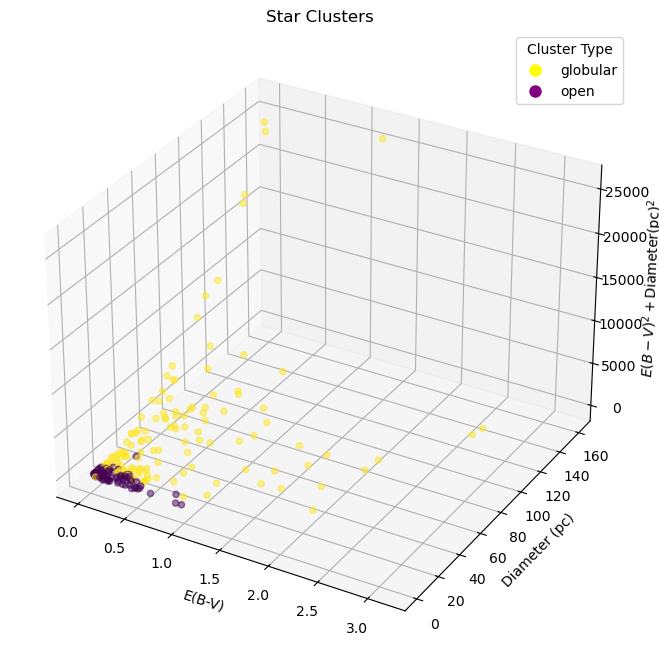

In [8]:
# Map cluster types to colors
# Globular = 1, Open = 0

# Calculate z-values
z_values = (clusters_df['E(B-V)'])**2 + (clusters_df['diameter (pc)'])**2

# Plot
fig = plt.figure(figsize = (8,10))
ax = fig.add_subplot(projection = '3d')
ax.scatter3D(clusters_df['E(B-V)'], clusters_df['diameter (pc)'], z_values, c = clusters_df['cluster_type'], label = clusters_df['cluster_type'], alpha = 0.5)
plt.title('Star Clusters')
ax.set_title('Star Clusters')
ax.set_xlabel('E(B-V)')
ax.set_ylabel('Diameter (pc)')
ax.set_zlabel(r'$E(B-V)^2 + \mathrm{Diameter (pc)}^2$')

# Add Legend, code generated by ChatGPT-4o, November 2024 ver. (OpenAI, 2024)
color_map = {'globular': 'yellow', 'open': 'purple'}
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=cluster_type)
    for cluster_type, color in color_map.items()
]
ax.legend(handles=handles, title="Cluster Type")

## Logistic Regression

### Create and Run Model

In [9]:
# Creating features and labels to train model
clust = clusters_df
features = clust.iloc[:,0:2]
label = clust['cluster_type']

# Defining model
train_vectors, test_vectors, train_labels, test_labels = sk.model_selection.train_test_split(features, label, test_size = 0.25, train_size = 0.75, random_state = 0)

# Training model
logit_model = sm.Logit(train_labels, sm.add_constant(train_vectors))
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.172415
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:           cluster_type   No. Observations:                  159
Model:                          Logit   Df Residuals:                      156
Method:                           MLE   Df Model:                            2
Date:                Sun, 17 Nov 2024   Pseudo R-squ.:                  0.7326
Time:                        12:43:49   Log-Likelihood:                -27.414
converged:                       True   LL-Null:                       -102.54
Covariance Type:            nonrobust   LLR p-value:                 2.371e-33
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -7.2803      1.594     -4.569      0.000     -10.404      -4.157
E(B-V)            4

### Prediction and Accuracy

In [10]:
# Predict data
prediction = result.predict(sm.add_constant(test_vectors))

# Finalize the predictions (if > 0.5 classify as 1, if <0.5, classify as 0), code generated by ChatGPT-4o - November 2024 ver. (OpenAI, 2024)
# Prompt: {I have an array of numbers from 0 to 1.0, how do I make it so that numbers less than 0.5 become 0 and numbers greater become 1}
prediction_labels = (prediction > 0.5).astype(float)

comparison = pd.concat([prediction_labels, test_labels], axis = 1)
comparison.columns = ["Prediction", "Actual"]

# Accuracy of prediction
print(comparison)
accuracy = accuracy_score(test_labels, prediction_labels)
print(f'Accuracy: {accuracy}')

     Prediction  Actual
710         0.0     0.0
46          0.0     1.0
105         0.0     1.0
346         0.0     0.0
184         1.0     0.0
89          0.0     1.0
115         1.0     1.0
60          0.0     0.0
6           0.0     1.0
97          1.0     1.0
67          1.0     1.0
120         0.0     0.0
277         0.0     0.0
134         1.0     1.0
88          1.0     1.0
803         0.0     0.0
149         1.0     1.0
17          0.0     1.0
208         0.0     0.0
251         0.0     0.0
467         0.0     0.0
739         0.0     0.0
712         0.0     0.0
590         0.0     0.0
111         0.0     0.0
24          1.0     1.0
410         0.0     0.0
21          1.0     1.0
100         1.0     1.0
85          1.0     1.0
9           0.0     1.0
75          1.0     1.0
104         0.0     0.0
116         1.0     1.0
42          0.0     0.0
296         0.0     0.0
40          1.0     1.0
210         0.0     0.0
106         1.0     1.0
632         0.0     0.0
127         1.0 

### Plotting Regression Model

/tmp/ipykernel_2328602/3573687266.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = result.params[0]
/tmp/ipykernel_2328602/3573687266.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  z_grid = intercept + coef[0] * x1_grid + coef[1] * x2_grid #Helped with ChatGPT-4, Prompt: "How to plot logistic regression plane in 3D". Accessed 11/17/2024.


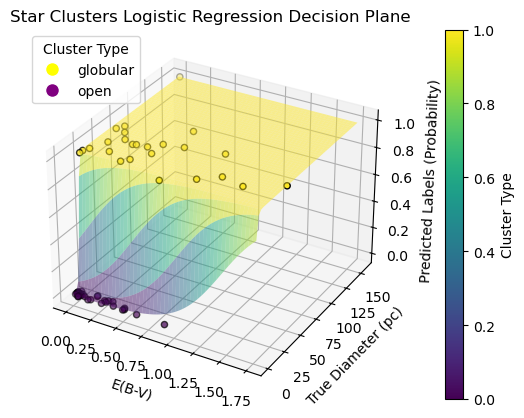

In [43]:
# Extracting the intercept and coefficients
intercept = result.params[0]
coef = result.params[1:]

# Creating grid for surface
x1_range = np.linspace(test_vectors['E(B-V)'].min(), test_vectors['E(B-V)'].max(), 50)  # Range for X1 (E(B-V))
x2_range = np.linspace(test_vectors['diameter (pc)'].min(), test_vectors['diameter (pc)'].max(), 50)  # Range for X2 (diameter)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)

# Compute log-odds for each point on the grid
z_grid = intercept + coef[0] * x1_grid + coef[1] * x2_grid #Helped with ChatGPT-4, Prompt: "How to plot logistic regression plane in 3D". Accessed 11/17/2024.

# Find probabilities
probabilities = 1 / (1 + np.exp(-z_grid))

# Plot regression points and surface
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
scatter = ax.scatter3D(test_vectors['E(B-V)'], test_vectors['diameter (pc)'], pred_labels, c = pred_labels, cmap='viridis', edgecolor = 'k')
ax.plot_surface(x1_grid, x2_grid, probabilities, alpha=0.5, cmap='viridis')

# Title and labels
plt.title('Star Clusters Logistic Regression Decision Plane')
ax.set_xlabel('E(B-V)')
ax.set_ylabel('True Diameter (pc)')
ax.set_zlabel('Predicted Labels (Probability)')
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Cluster Type')

# Add legend, code generated by ChatGPT-4o, November 2024 ver. (OpenAI, 2024)
color_map = {'globular': 'yellow', 'open': 'purple'}
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=cluster_type)
    for cluster_type, color in color_map.items()
]
ax.legend(handles=handles, title="Cluster Type")
plt.show()

## Data Analysis for Logistic Regression

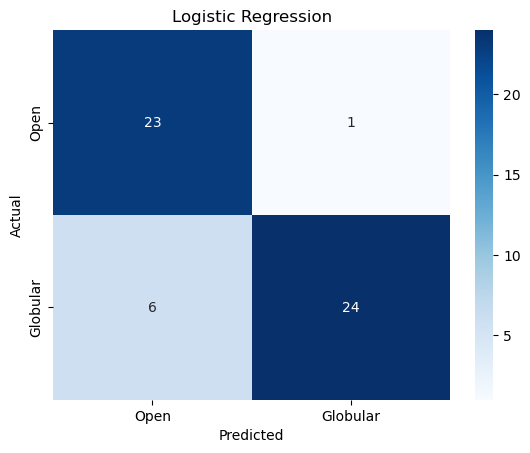

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_labels = ['Open', 'Globular']

# Visualize confusion matrix as a heatmap
cm = confusion_matrix(test_labels, prediction_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels = class_labels, yticklabels = class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression")
plt.show()


With an accuracy rate of roughly 0.87, the Logistic Regression model performed fairly well. The model was trained with a test sample and train sample of 25% and 75% respectively. As observed from the confusion matrix, it has a false open rate of roughly 0.207 and a false globular rate of roughly 0.04, the model seems to have more difficulty identifying open clusters as opposed to to globular clusters. This is perhaps understandable as the `open_cluster` dataset had more NaN values that we had to get rid of, resulting in fewer data points. The model might not have had enough data to be trained on. This model could be more refined if 